# Parte 1:

## Dado o sistema do slide 20 da apresentação 04 - Função de Transferência Amostrada:

# <h1><center>$a = e^{-T/RC}\quad b = 1-e^{-T/RC}$</center></h1> 

## Considere RC = 0,083 s  e T = 0,1 s

## Com o Matlab ou equivalente:

- Obtenha a função de transferência discreta equivalente;

- Verifique a resposta do sistema para uma entrada do tipo degrau unitário com a função step;

- Obtenha a equação recursiva do sistema;

- Verifique a resposta do sistema para uma entrada do tipo degrau unitário utilizando a equação recursiva;

- Verifique a resposta do sistema (solução exata) para uma entrada do tipo degrau unitário utilizando a transformada Z inversa da expressão Y(z) = H(z)E(z);

- Compare as respostas

In [1]:
import numpy as np
import lcapy as lcp
from lcapy import t, s
from lcapy.discretetime import n, z       # Pacote localizado em https://pypi.org/project/lcapy/
                                          # e documentação em https://lcapy.readthedocs.io/en/latest/
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':[16,9],
                     'font.size': 22, 
                     'xaxis.labellocation': 'right',
                     'yaxis.labellocation': 'top'})

# 1. Obter a função de transferência discreta equivalente:

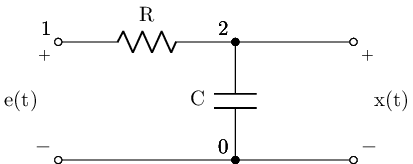

In [2]:
# Circuito RC:
cct = lcp.Circuit("""
... P1 1 0_1; down, v=e(t)
... R 1 2; right, size=1.5, scale=0.8, l^=R
... C 2 0; down, scale=0.8, l_=C
... P2 2_2 0_2; down, v^=x(t)
... W 2 2_2; right
... W 0_1 0; right
... W 0 0_2; right""");
cct.draw();

In [3]:
# Função de transferência G(s) proveniente do circuito RC:
G = cct.P1.transfer('P2');
G

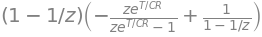

In [4]:
# Função de transferência H(z):
C = lcp.symbol('C', positive=True);
T = lcp.symbol('T', positive=True);
g = (G/s)(t);
G = ((g(n)).subs({'C' : C/T}))(z);
H = (1-z**-1)*G;
H

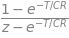

In [5]:
H = H.canonical();
H

# 2. Obter a equação recursiva do sistema:

<font size="5">
\begin{align*}
Y(z) &= H(z) \cdot E(z) \\
Y(z) &= \left( \frac{1-e^{\frac{-T}{R \cdot C}}}{z-e^{\frac{-T}{R \cdot C}}} \right) \cdot E(z) \\
Y(z) \cdot \left( z-e^{\frac{-T}{R \cdot C}} \right) &= E(z) \cdot \left( 1-e^{\frac{-T}{R \cdot C}} \right) \\
z \cdot Y(z) - e^{\frac{-T}{R \cdot C}} \cdot Y(z) &= \left( 1 - e^{\frac{-T}{R \cdot C}} \right) \cdot E(z) \\
\mathcal{Z^{-1}} \left[ z \cdot Y(z) - e^{\frac{-T}{R \cdot C}} \cdot Y(z) \right]  &= \mathcal{Z^{-1}} \left[ \left( 1 - e^{\frac{-T}{R \cdot C}} \right) \cdot E(z) \right] \\
y(kT + T) - e^{\frac{-T}{R \cdot C}} \cdot y(kT) &= \left( 1 - e^{\frac{-T}{R \cdot C}} \right) \cdot e(kT) \\
y(kT + T) &= e^{\frac{-T}{R \cdot C}} \cdot y(kT) + \left( 1 - e^{\frac{-T}{R \cdot C}} \right) \cdot e(kT) \\
y(kT + T) &= a \cdot y(kT) + b \cdot e(kT)
\end{align*}
</font>

# 3. Obter a resposta exata do sistema para uma entrada do tipo degrau unitário:

In [6]:
# Resposta Y(z) à entrada E(z):
E = lcp.expr('z/(z-1)');
Y = H*E;
Y = Y/z;
Y = (Y.partfrac()*z).expand();
Y

In [7]:
# Transformada Z inversa de Y(z):
y = Y(n, causal=True);
y

# 4. Elaboração do gráficos das expressões recursiva e exata:

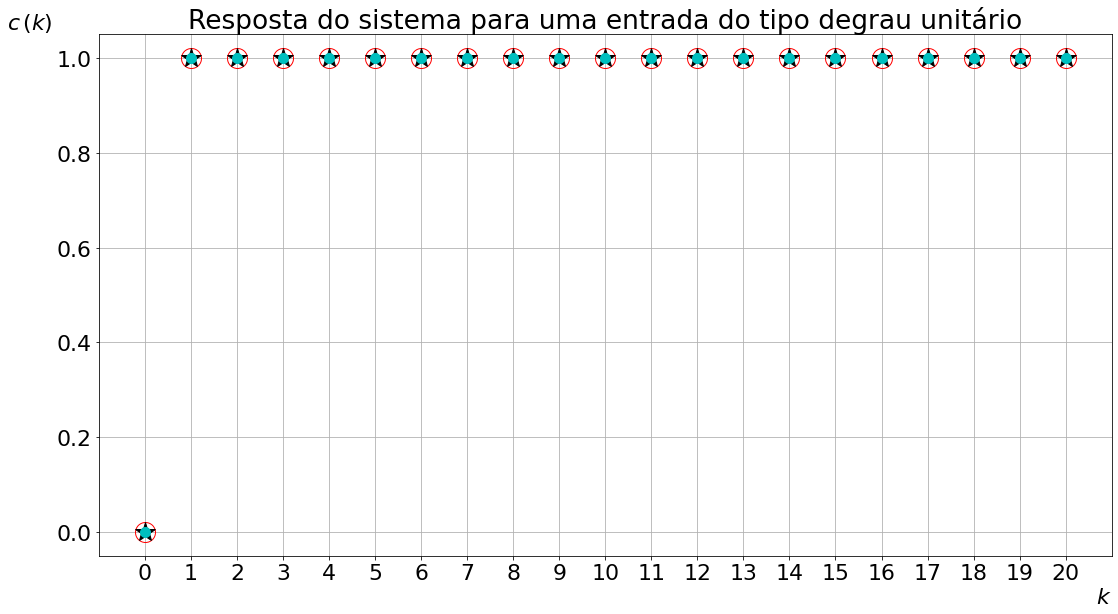

In [8]:
R = 1000;
C = 83e-6;
RC = R*C;
T = 1;
a = np.exp(-T/RC);
b = 1-np.exp(-T/RC);
defs = {'R' : R, 'C' : C, 'T' : T, 'e' : lcp.exp(1)};   

tfinal = 20;
Kmax = int(tfinal/T+1);
k = np.linspace(0, tfinal, Kmax);

ys = (y.subs(defs)).seq(nvals=(0,Kmax));          # Expressão exata obtida a partir do das funções da biblioteca lcapy
ys = ys.zeroextend();

recursiva = np.zeros(Kmax);
e = np.heaviside(k,1);

for i in range(1, Kmax):
    recursiva[i] = a * recursiva[i-1] + b*e[i-1]; # Equação recursiva
    
exata = (1-np.exp(-k*T/RC))*np.heaviside(k,1);    # Equação exata obtida a partir do equacionamento

plt.plot(ys.n, ys.as_array(), 'ro', markerfacecolor='None', markersize=20);
plt.plot(k, recursiva, 'k*', markersize=20);
plt.plot(k, exata, 'c.', markersize=20);
plt.xticks(np.arange(min(k), max(k)+1, 1.0));
plt.title("Resposta do sistema para uma entrada do tipo degrau unitário");
plt.xlabel("$k$");
plt.ylabel("$c \, (k)$", rotation=0);
plt.grid();
plt.tight_layout();
plt.show();

# 5. Comparação entre os valores obtidos das curvas:

## Todas as expressões tiveram os mesmos resultados como pode ser observado na figura acima, aonde os pontos das curvas se coincidiram.